# Week 3: Spectral Properties of LFP

This notebook explores spectral analysis methods for local field potential (LFP)
signals recorded during spatial navigation.

## Learning Objectives

By the end of this notebook, you will be able to:

1. Load and visualize LFP data from NWB files
2. (More objectives to be added)

## Setup

In [1]:
# Install dependencies (required for Google Colab)
import subprocess
import sys

if "google.colab" in sys.modules:
    subprocess.check_call(
        [
            sys.executable,
            "-m",
            "pip",
            "install",
            "-q",
            "pynwb",
            "hdmf",
            "dandi",
            "remfile",
            "h5py",
            "fsspec",
            "aiohttp",
            "requests",
        ]
    )

In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from dandi.dandiapi import DandiAPIClient
from pynwb import NWBHDF5IO
from remfile import File as RemoteFile

## Load Data from DANDI

We need two files for this analysis:
1. The **behavior file** containing speed data
2. The **LFP file** containing the raw electrophysiology data

In [3]:
# Define the dataset location on DANDI
DANDISET_ID = "000059"
DANDISET_VERSION = "0.230907.2101"

# Behavior file (contains speed)
BEHAVIOR_ASSET_PATH = (
    "sub-MS22/"
    "sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-processed_behavior+ecephys.nwb"
)

# LFP file (contains raw electrophysiology)
LFP_ASSET_PATH = (
    "sub-MS22/"
    "sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-raw_ecephys.nwb"
)

### Load Behavior Data (Speed)

In [4]:
# Connect to DANDI and get the streaming URL for behavior file
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(DANDISET_ID, DANDISET_VERSION)
    behavior_asset = dandiset.get_asset_by_path(BEHAVIOR_ASSET_PATH)
    behavior_s3_url = behavior_asset.get_content_url(follow_redirects=1, strip_query=True)

print(f"Behavior file: {BEHAVIOR_ASSET_PATH}")
print(f"Streaming from: {behavior_s3_url[:80]}...")

Behavior file: sub-MS22/sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-processed_behavior+ecephys.nwb
Streaming from: https://dandiarchive.s3.amazonaws.com/blobs/075/b32/075b32be-1c44-4e2f-8a91-3eeb...


In [5]:
# Open the behavior NWB file
behavior_remote_file = RemoteFile(behavior_s3_url)
behavior_h5_file = h5py.File(behavior_remote_file, "r")
behavior_io = NWBHDF5IO(file=behavior_h5_file, load_namespaces=True)
behavior_nwbfile = behavior_io.read()

print(f"Session: {behavior_nwbfile.identifier}")

Session: 7931d1a7-09c5-457f-9f0a-22d952d8b818


In [6]:
# Extract speed data
behavior_module = behavior_nwbfile.processing["behavior"]

speed_interface = next(
    interface
    for name, interface in behavior_module.data_interfaces.items()
    if "speed" in name.lower()
)

speed_data = speed_interface.data[:]
speed_timestamps = speed_interface.timestamps[:]

print(f"Speed data shape: {speed_data.shape}")
print(f"Speed time range: {speed_timestamps[0]:.1f} - {speed_timestamps[-1]:.1f} s")
print(f"Speed unit: {speed_interface.unit}")

Speed data shape: (198664,)
Speed time range: 6348.1 - 8003.6 s
Speed unit: cm/s


In [7]:
# Also get position for reference
position_interface = next(
    interface
    for name, interface in behavior_module.data_interfaces.items()
    if "position" in name.lower()
)
spatial_series = next(iter(position_interface.spatial_series.values()))
position_timestamps = spatial_series.timestamps[:]

print(f"Position time range: {position_timestamps[0]:.1f} - {position_timestamps[-1]:.1f} s")

Position time range: 6348.1 - 8003.6 s


In [8]:
# Get electrodes info (for theta reference channel)
electrodes_df = behavior_nwbfile.electrodes.to_dataframe()

if "theta_reference" in electrodes_df.columns:
    theta_ref_indices = np.nonzero(electrodes_df["theta_reference"].values)[0]
    if len(theta_ref_indices) > 0:
        theta_ref_channel = theta_ref_indices[0]
        print(f"Theta reference channel: {theta_ref_channel}")
else:
    theta_ref_channel = 0
    print(f"No theta reference found, using channel {theta_ref_channel}")

Theta reference channel: 6


### Load LFP Data

In [9]:
# Get streaming URL for LFP file
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(DANDISET_ID, DANDISET_VERSION)
    lfp_asset = dandiset.get_asset_by_path(LFP_ASSET_PATH)
    lfp_s3_url = lfp_asset.get_content_url(follow_redirects=1, strip_query=True)

print(f"LFP file: {LFP_ASSET_PATH}")
print(f"Streaming from: {lfp_s3_url[:80]}...")

LFP file: sub-MS22/sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-raw_ecephys.nwb
Streaming from: https://dandiarchive.s3.amazonaws.com/blobs/5ff/17f/5ff17f89-382d-400b-8501-028f...


In [10]:
# Open the LFP NWB file
lfp_remote_file = RemoteFile(lfp_s3_url)
lfp_h5_file = h5py.File(lfp_remote_file, "r")
lfp_io = NWBHDF5IO(file=lfp_h5_file, load_namespaces=True)
lfp_nwbfile = lfp_io.read()

print(f"LFP Session: {lfp_nwbfile.identifier}")

LFP Session: 50906443-9caf-41e1-aaa7-c07c4dbede84


In [11]:
# Get LFP electrical series
lfp_electrical_series = next(iter(lfp_nwbfile.acquisition.values()))

print(f"LFP data shape: {lfp_electrical_series.data.shape}")
print(f"LFP sampling rate: {lfp_electrical_series.rate} Hz")
print(f"Number of channels: {lfp_electrical_series.data.shape[1]}")

LFP data shape: (243000720, 128)
LFP sampling rate: 20000.0 Hz
Number of channels: 128


In [12]:
# Load a segment of LFP data for analysis
# We'll load data corresponding to the behavior epoch
# Note: LFP timestamps start at 0, behavior timestamps start later

lfp_rate = lfp_electrical_series.rate
n_lfp_samples = lfp_electrical_series.data.shape[0]
lfp_duration = n_lfp_samples / lfp_rate

print(f"LFP duration: {lfp_duration:.1f} s")
print(f"LFP time range: 0 - {lfp_duration:.1f} s")

LFP duration: 12150.0 s
LFP time range: 0 - 12150.0 s


In [13]:
# Load a sample of LFP from the theta reference channel
# Start with first 10 seconds for initial visualization
SAMPLE_DURATION = 10  # seconds
n_samples = int(SAMPLE_DURATION * lfp_rate)

lfp_sample = lfp_electrical_series.data[:n_samples, theta_ref_channel]
lfp_time = np.arange(n_samples) / lfp_rate

print(f"Loaded {SAMPLE_DURATION}s of LFP from channel {theta_ref_channel}")
print(f"Sample shape: {lfp_sample.shape}")

Loaded 10s of LFP from channel 6
Sample shape: (200000,)


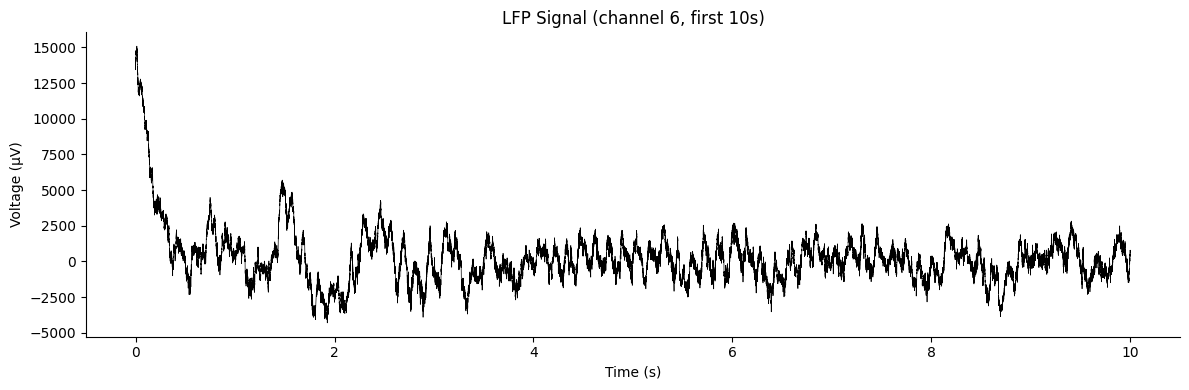

In [14]:
# Plot LFP trace
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(lfp_time, lfp_sample, linewidth=0.5, color="black")

ax.set(
    xlabel="Time (s)",
    ylabel="Voltage (µV)",
    title=f"LFP Signal (channel {theta_ref_channel}, first {SAMPLE_DURATION}s)",
)

ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.show()

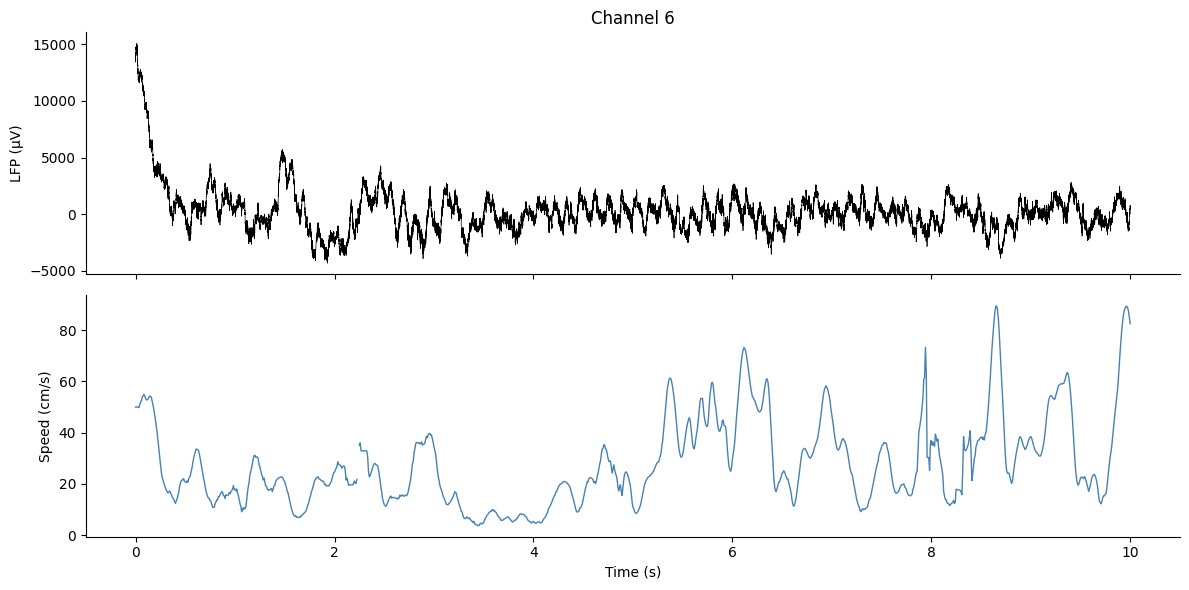

In [15]:
# Plot speed for the same time period (need to align timestamps)
# Speed timestamps are offset from LFP timestamps
speed_offset = speed_timestamps[0]  # Speed starts at this time in the session

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# LFP
ax = axes[0]
ax.plot(lfp_time, lfp_sample, linewidth=0.5, color="black")
ax.set_ylabel("LFP (µV)")
ax.set_title(f"Channel {theta_ref_channel}")
ax.spines[["top", "right"]].set_visible(False)

# Speed (shifted to align with LFP time)
ax = axes[1]
# Find speed samples in the first 10 seconds of the session
speed_mask = (speed_timestamps - speed_offset) < SAMPLE_DURATION
if speed_mask.any():
    ax.plot(
        speed_timestamps[speed_mask] - speed_offset,
        speed_data[speed_mask],
        linewidth=1,
        color="steelblue",
    )
ax.set_xlabel("Time (s)")
ax.set_ylabel(f"Speed ({speed_interface.unit})")
ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.show()

## Data Summary

We now have loaded:
- **LFP data**: Raw electrophysiology from the theta reference channel
- **Speed data**: Animal's running speed during the task

The LFP and speed are recorded on different time bases:
- LFP starts at time 0
- Speed/behavior starts at a later time in the session

For analysis, we'll need to align these signals appropriately.

In [16]:
print("Data Summary")
print("=" * 50)
print(f"LFP sampling rate: {lfp_rate} Hz")
print(f"LFP duration: {lfp_duration:.1f} s")
print(f"LFP channels: {lfp_electrical_series.data.shape[1]}")
print(f"Theta reference channel: {theta_ref_channel}")
print()
print(f"Speed samples: {len(speed_data)}")
print(f"Speed time range: {speed_timestamps[0]:.1f} - {speed_timestamps[-1]:.1f} s")
print(f"Behavior epoch offset: {speed_offset:.1f} s from session start")

Data Summary
LFP sampling rate: 20000.0 Hz
LFP duration: 12150.0 s
LFP channels: 128
Theta reference channel: 6

Speed samples: 198664
Speed time range: 6348.1 - 8003.6 s
Behavior epoch offset: 6348.1 s from session start


## Cleanup

In [17]:
# Close both file handles
behavior_io.close()
lfp_io.close()